In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import pandas as pd
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28, 120)
        self.fc2 = nn.Linear(120, 20)
        self.fc3 = nn.Linear(20, 18)
        # self.fc4 = nn.Linear(12, 2)
        # self.fc5 = nn.Linear(32, 28)
        # self.fc6 = nn.Linear(28, 24)
        # self.fc7 = nn.Linear(24, 18)

    def forward(self, x):
        # print("type x", type(x))
        # x = self.fc1(x)
        # x = F.relu(x)
        # x = self.fc2(x)
        # x = F.relu(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        # x = F.relu(x)
        # x = self.fc4(x)
        # x = F.relu(x)
        # x = self.fc5(x)
        # x = F.relu(x)
        # x = self.fc6(x)
        # x = F.relu(x)
        # x = self.fc7(x)
        return x

In [9]:
class CustomDataset(Dataset):
    def __init__(self, file_path):
        df = pd.read_csv(file_path)
        self.x = df.iloc[:,0].values
        self.y = df.iloc[:,1].values
        # self.a = df.iloc[:, 0].values
        # self.b = df.iloc[:, 1].values
        # self.c = df.iloc[:, 2].values
        # self.y = df.iloc[:, 3].values
        # self.y = list(map(self.string_to_vector, self.y))
        self.length = len(df)

    # def string_to_vector(self, value):
    #     data = {"acute triangle": 0, "right triangle":1, "obtuse triangle": 2}
    #     return data.get(value, None)

    def __getitem__(self, index):
        x = self.x[index]
        # x = list(str(x))[:-6]
        # x = list(map(int, x))
        # while(len(x)<8):
        #     x.insert(0, 0)
        x = list(x)[:-6]
        x = list(map(int, x))
        x = torch.FloatTensor(x)
        # x = torch.FloatTensor(sorted([self.a[index], self.b[index], self.c[index]]))
        y = torch.LongTensor(self.y)[index]
        # print(x, y)
        return x, y

    def __len__(self):
        return self.length

In [10]:
# train_dataset = CustomDataset("txt/data2.csv")
# full_dataset = CustomDataset("txt/data.csv")
full_dataset = CustomDataset("/content/drive/MyDrive/hash/txt/data_Xeon.csv")
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

# train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
# test_dataloader = DataLoader(test_dataset, batch_size=1)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Net().to(device)
print(model)

Net(
  (fc1): Linear(in_features=28, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=12, bias=True)
  (fc4): Linear(in_features=12, out_features=2, bias=True)
)


In [11]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [12]:
losses = []

indices = torch.randperm(len(train_dataset))[:65536]
sampler = SubsetRandomSampler(indices)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False, drop_last=True, sampler=sampler)

for epoch in range(10000):
    cost = 0.0

    # indices = torch.randperm(len(train_dataset))[:129536]
    # sampler = SubsetRandomSampler(indices)
    # train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False, drop_last=True, sampler=sampler)

    for i, batch in enumerate(tqdm(train_dataloader)):
    # for x, y in train_dataloader:
        x = batch[0].to(device)
        y = batch[1].to(device)
        # x = x.to(device)
        # y = y.to(device)
        optimizer.zero_grad()
        # print(x, y)
        
        output = model(x)
        # print(type(output), output.shape, y.shape)
        # print(output, y)
        loss = criterion(output, y)

        loss.backward()
        optimizer.step()

        cost += loss

        # print(f"Epoch : {epoch+1:4d}, Loss : {loss:.3f}")

    cost = cost / len(train_dataloader)
    losses.append(cost)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch : {epoch+1:4d}, Cost : {cost:.3f}")

Epoch :   10, Cost : 0.693
Epoch :   20, Cost : 0.693
Epoch :   30, Cost : 0.693
Epoch :   40, Cost : 0.693
Epoch :   50, Cost : 0.692
Epoch :   60, Cost : 0.692
Epoch :   70, Cost : 0.691
Epoch :   80, Cost : 0.690
Epoch :   90, Cost : 0.688
Epoch :  100, Cost : 0.686
Epoch :  110, Cost : 0.684
Epoch :  120, Cost : 0.680
Epoch :  130, Cost : 0.677
Epoch :  140, Cost : 0.674
Epoch :  150, Cost : 0.668
Epoch :  160, Cost : 0.658
Epoch :  170, Cost : 0.285
Epoch :  180, Cost : 0.256
Epoch :  190, Cost : 0.068
Epoch :  200, Cost : 0.024
Epoch :  210, Cost : 0.020
Epoch :  220, Cost : 0.017
Epoch :  230, Cost : 0.014
Epoch :  240, Cost : 0.011
Epoch :  250, Cost : 0.010
Epoch :  260, Cost : 0.300
Epoch :  270, Cost : 0.089


KeyboardInterrupt: ignored

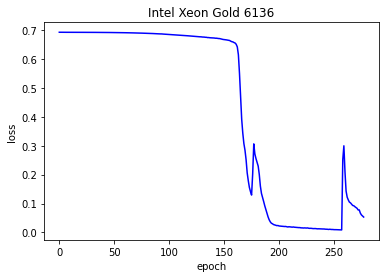

100%|██████████| 10000/10000 [00:04<00:00, 2315.96it/s]

--------------
Accuracy:  97.33000000000001


In [13]:
losses_int = [ts.item() for ts in losses]
plt.plot(losses_int, 'b')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Intel Xeon Gold 6136')
plt.show()

indices = torch.randperm(len(test_dataset))[:10000]
sampler = SubsetRandomSampler(indices)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, drop_last=True, sampler=sampler)

# GET OUTPUT
with torch.no_grad():
    model.eval()
    
    total = 0
    correct = 0

    for i, batch in enumerate(tqdm(test_dataloader)):
        x = batch[0].to(device)
        y = batch[1].to(device)
        # x = x.to(device)
        # y = y.to(device)
        output = model(x)
        y_pred = torch.argmax(output, dim=1).to(device)
        total += 1
        # print(x, y, y_pred)
        if (y == y_pred): 
            correct += 1

print('--------------')
print('Accuracy: ', correct / total * 100)